In [1]:
def hama_response(N):
    filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--00000.dat'
    time,h = np.loadtxt(filename,unpack=True)
    ids = np.random.randint(1,300,size=(N-1,1))
    for id in ids:
        filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--%05i.dat' % id
        time,hi = np.loadtxt(filename,unpack=True)
        h = np.row_stack((h,hi))
    return time,h

In [2]:
def sample_distribution(axis,pde,N):
    #this function takes in a sampling axis and a corresponding distribution and produce indices of N samples. 
    fig = plt.figure()
    plt.plot(axis,pde)
    plt.grid(True)
    plt.title('PDE')
    
    ids=np.empty([0])
    while ids.size!=N:
        for i in range(len(pde)):
            if np.random.choice([1,0], p=[pde[i],1-pde[i]]) == 1:
                ids = np.append(ids,i)
                ids = np.unique(ids)
                break
    ids = ids.astype(int)
    ids = np.resize(ids,(N,1))
    return axis[ids]

<IPython.core.display.Javascript object>


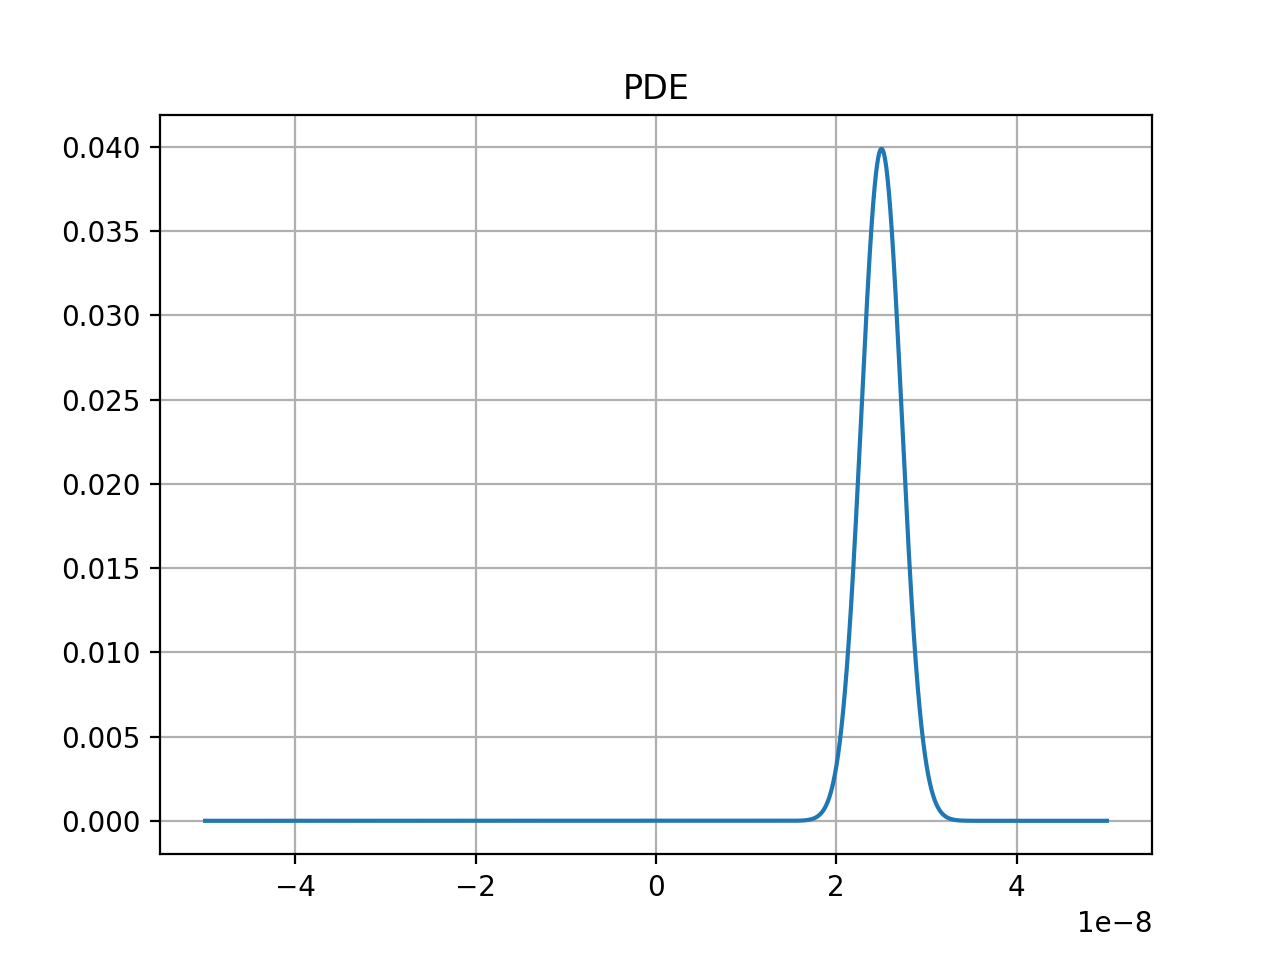

<IPython.core.display.Javascript object>


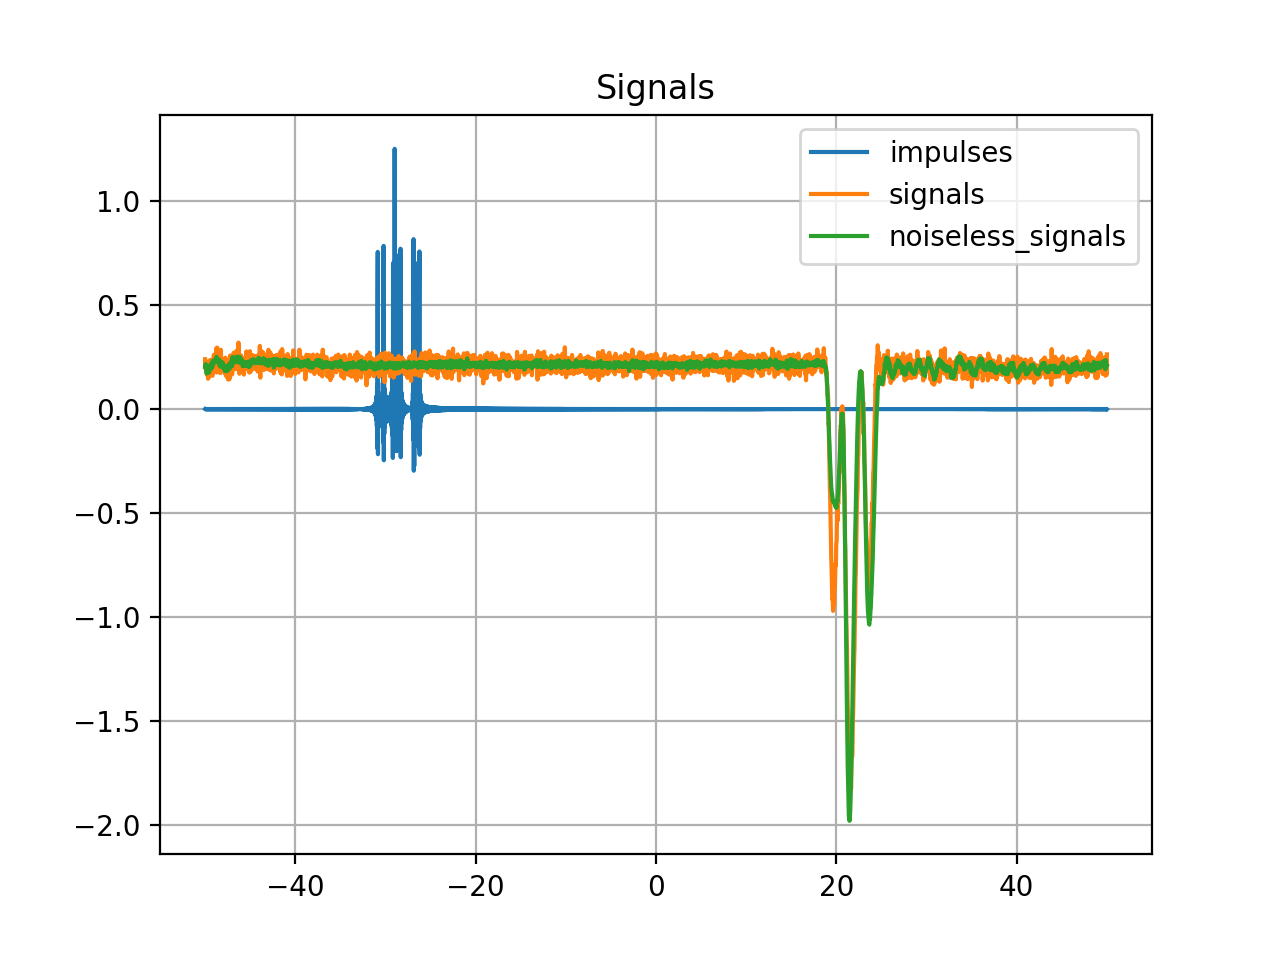

In [3]:
%matplotlib notebook

import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
import matplotlib.pyplot as plt

N = 10

timeaxis, h = hama_response(N)
havg = np.mean(h,axis=0)
H = fft(h,axis=1)
Havg = fft(havg)

freq = fftfreq(timeaxis.size,d = timeaxis[1]-timeaxis[0])

#define gaussian probability distribution of hits
rate = 1.0   #sampling rate
width = 10.0  #gaussian width

#define your distribution here
pde = (1/np.sqrt(width**2*np.pi*2))*np.exp(-(rate*(timeaxis-timeaxis[3*timeaxis.size/4])*1.0e9)**2/width)
rand_time = sample_distribution(timeaxis,pde,N)

S = np.exp(-2*np.pi*1j*freq*rand_time)
G = S*H

S = np.sum(S,axis=0)

Gavg = S*Havg
G = np.sum(G,axis=0)

s = np.real(ifft(S))
g = np.real(ifft(G))
gavg = np.real(ifft(Gavg))

fig = plt.figure()
ax = fig.subplots()
ax.plot(timeaxis*1.0e9,s,label='impulses')
ax.plot(timeaxis*1.0e9,g,label='signals')
ax.plot(timeaxis*1.0e9,gavg,label='noiseless_signals')
ax.set_title(label='Signals')
ax.grid(True)
ax.legend()
#fig = plt.figure()
#plt.plot(freq,np.abs(Havg))

In [4]:
def generate_convolmatrix(havg):
    hmat = np.zeros((havg.size,havg.size))
    for i in range(havg.size-1):
        for k in range(i+1):
            hmat[i][k]=havg[i-k]
    return hmat

Time elapsed= 2152 ms


<IPython.core.display.Javascript object>


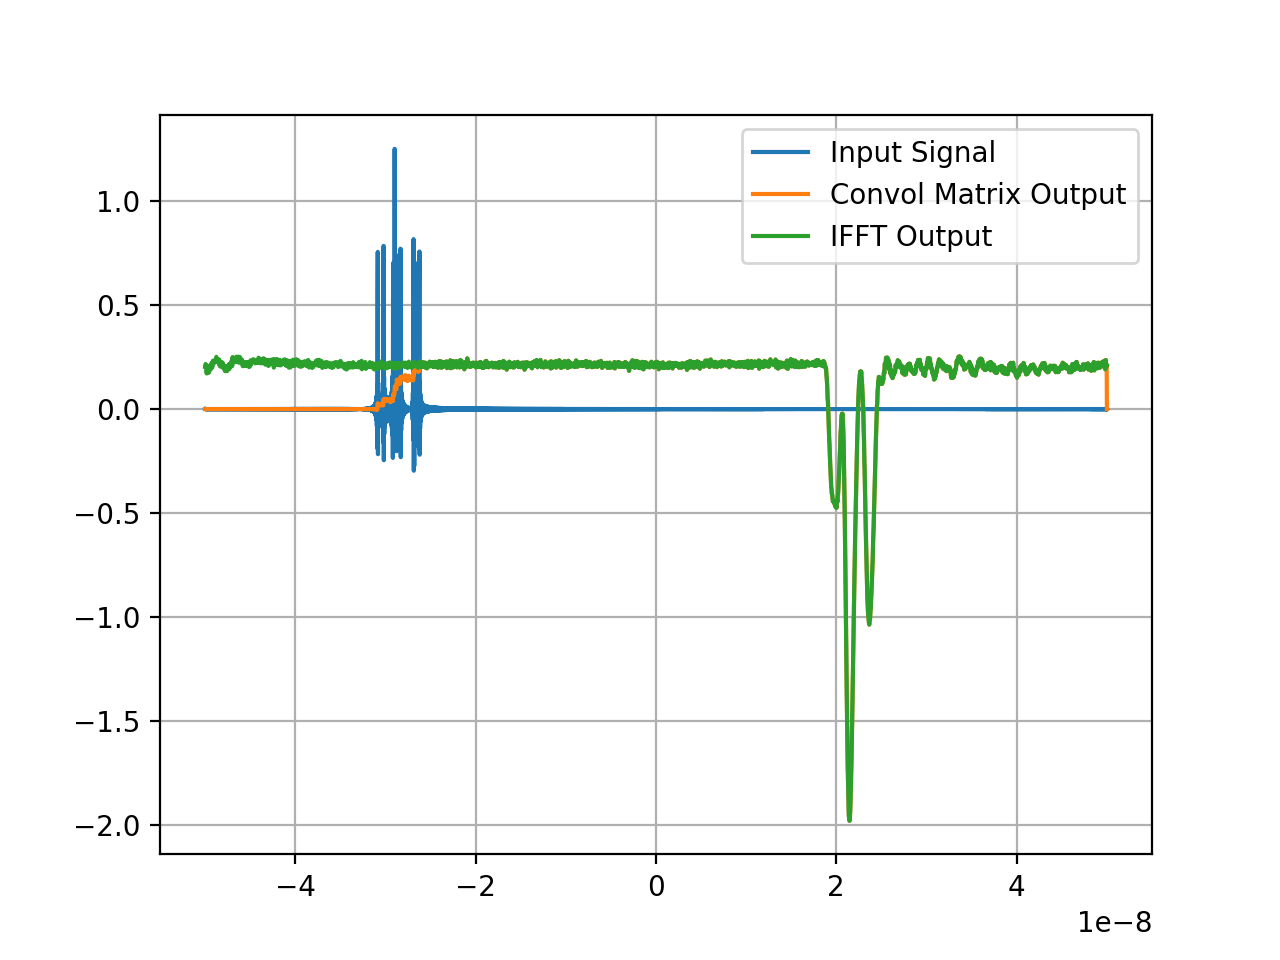

In [5]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time 

"""
Now we need to figure out how to deconvolve gavg(t) into s(t) without going to the fourier domain.
This would help us to generate a filter set which can be inmplemented on FPGA without the cost of implementing FFT
We can use TD Deconvolution method when kernel has no spectral inverse. This is the first step towards this goal.

Note on time complexity: ~O(n^2) time for n points in signal but this is a one time assignment operation.
The signal for t<0 doesnt agree completely but s(t<0) is meaningless in the context of real signals.
I tried to find the inverse using hmat^-1 but the spectrum contains zeros!
"""
#generate complete convolution matrix
start = time.time()

hmat = generate_convolmatrix(havg)
y = np.matmul(hmat,s)

end = time.time()
print 'Time elapsed= %i ms'%((end - start)*1000)

fig = plt.figure()
plt.plot(timeaxis,s,label='Input Signal')
plt.plot(timeaxis,y,label='Convol Matrix Output')
plt.plot(timeaxis,gavg,label='IFFT Output')
plt.grid(True)
plt.legend()

In [6]:
def generate_sparse_convolmatrix(havg):
    hsparse = sparse.lil_matrix((havg.size,havg.size))
    for i in range(havg.size-1):
        hsparse[i,:(i+1)]=havg[i+1:0:-1]
    return hsparse

<IPython.core.display.Javascript object>


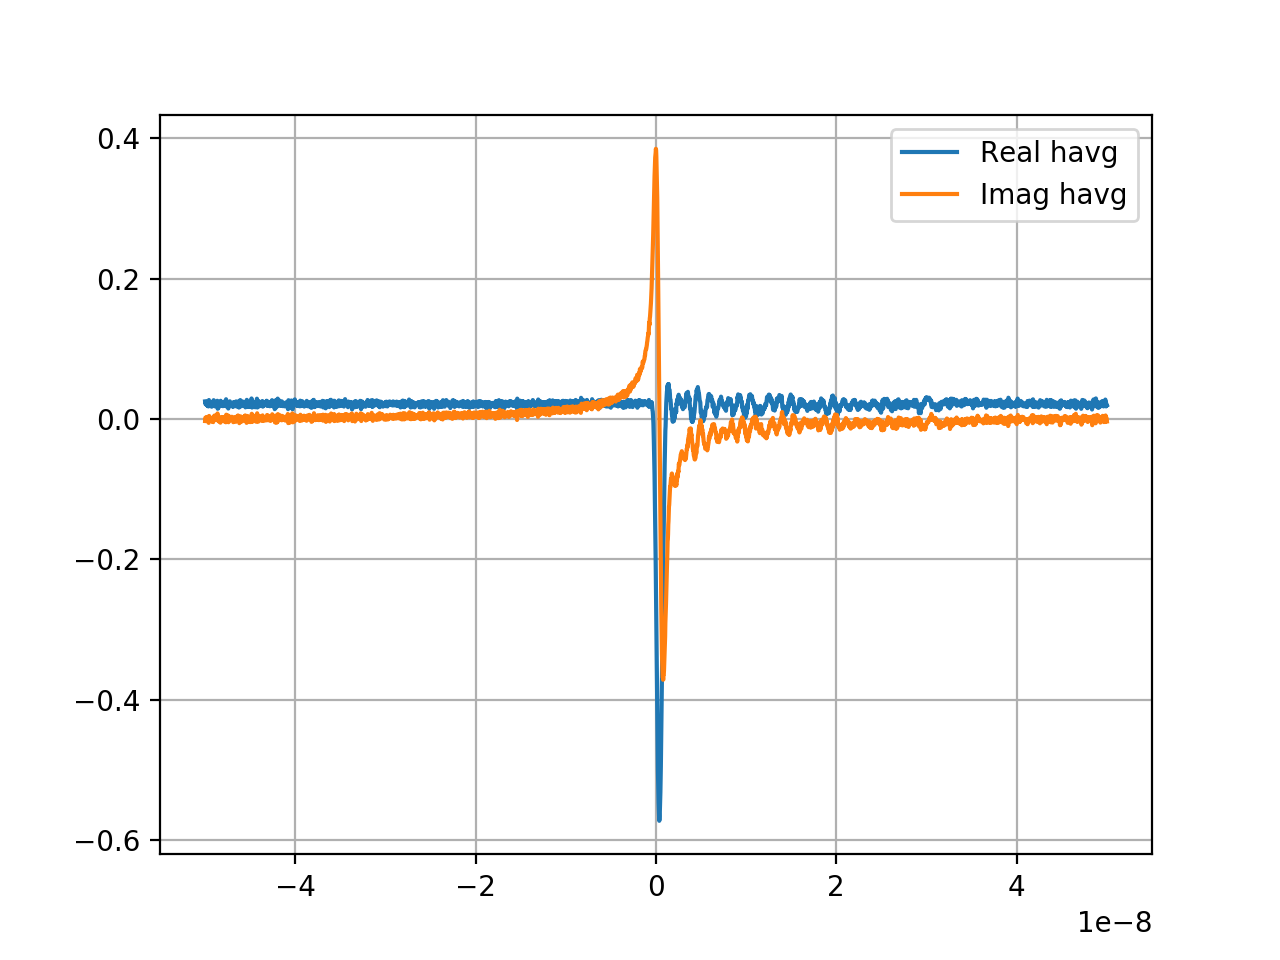

<IPython.core.display.Javascript object>


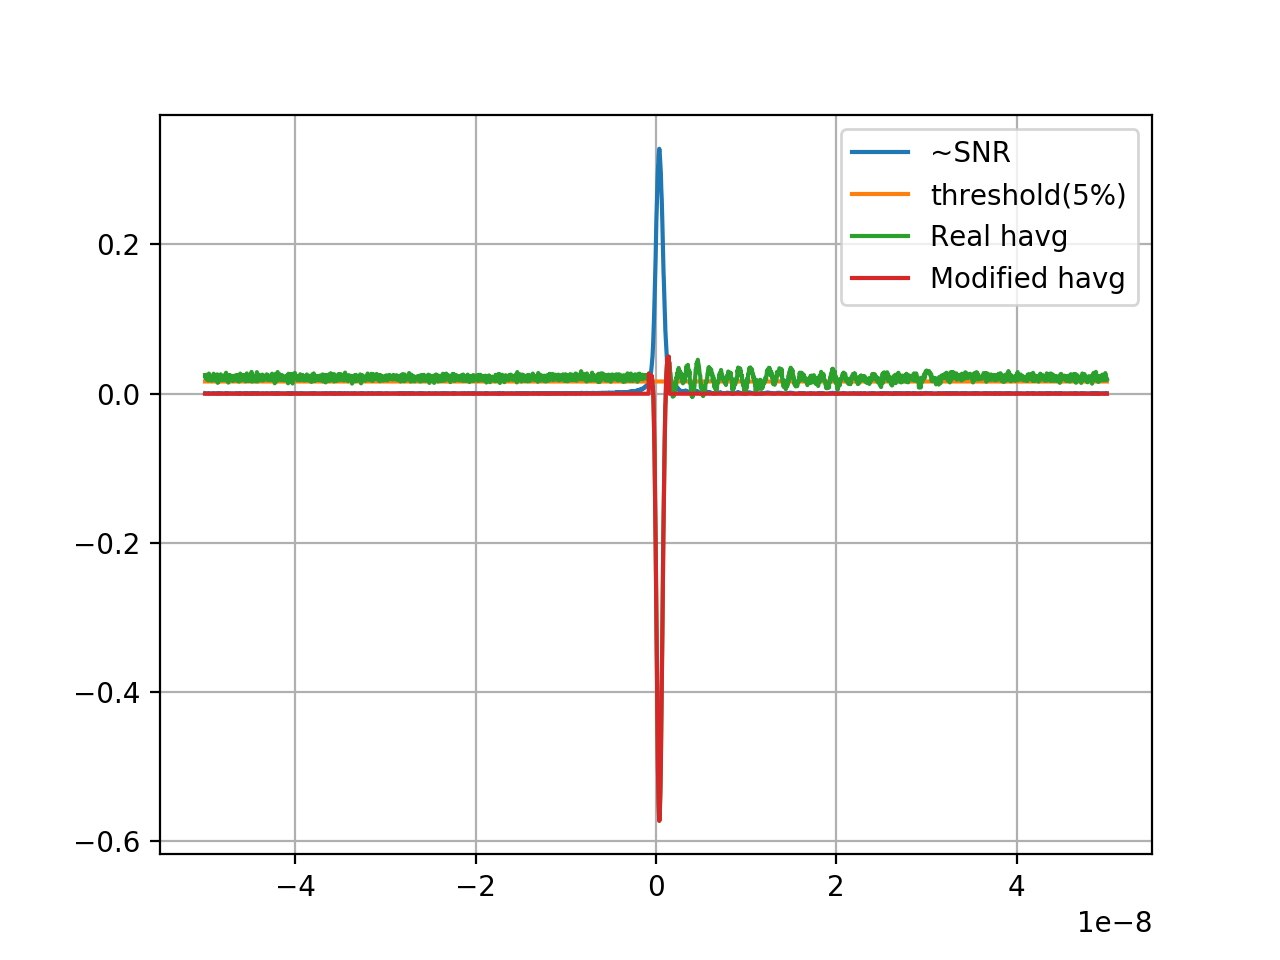

Time elapsed= 500 ms


<IPython.core.display.Javascript object>


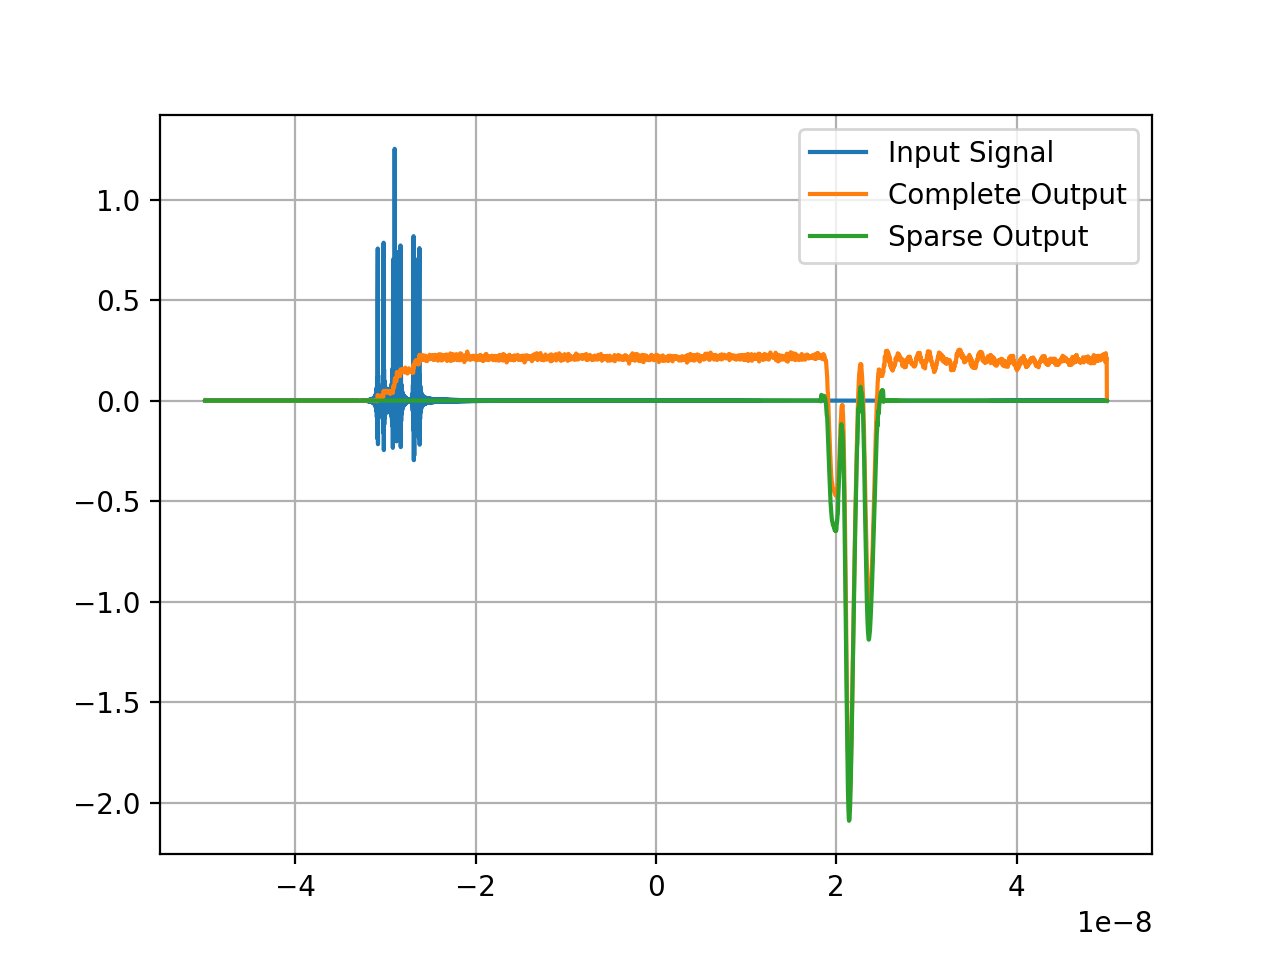

In [7]:
"""
Discrete hilbert transform(basis for Kramer-Kronig) is obtained with the motivation of chopping the havg for sparse
convolution matrix. Chopping is done at 95% of the peak value of ~SNR(reasonable but kind of arbitrary now, may 
require some PSD analysis to make more accurate)"""

from scipy.signal import hilbert
from scipy import sparse
import time

thr = []
frac =0.05
#havg_re = np.real(hilbert(havg)) #equivalent to havg
havg_im = np.imag(hilbert(havg))
snr = np.abs(havg)**2+np.abs(havg_im)**2
for i in range(havg.size):
    thr.append(frac*max(snr))

havg_mod = np.zeros(havg.size)
for i in range(havg.size):
    if snr[i]>=thr[0]:
        havg_mod[i] = havg[i]
fig = plt.figure()
plt.plot(timeaxis,havg,label='Real havg')
plt.plot(timeaxis,havg_im,label='Imag havg')
plt.grid(True)
plt.legend()

fig = plt.figure()
plt.plot(timeaxis,snr,label='~SNR')
plt.plot(timeaxis,thr,label='threshold(%i%%)'%(frac*100))
plt.plot(timeaxis,havg,label='Real havg')
plt.plot(timeaxis,havg_mod,label='Modified havg')
plt.grid(True)
plt.legend()

#count number of non-zero, havg_mod entries
"""nz_count = 0
for i in range(havg_mod.size):
    if havg_mod[i]!=0:
        nz_count += 1
print nz_count"""

#generate sparse convolution matrix
start = time.time()

hsparse = generate_sparse_convolmatrix(havg_mod)
s_cpy = sparse.lil_matrix((1,s.size))
s_cpy[:] = s[:]
y_mod = (hsparse.tocsr()*s_cpy.tocsr().transpose())

end = time.time()
print 'Time elapsed= %i ms'%((end - start)*1000)

fig = plt.figure()
plt.plot(timeaxis,s,label='Input Signal')
plt.plot(timeaxis,y,label='Complete Output')
plt.plot(timeaxis,y_mod.todense(),label='Sparse Output')
plt.grid(True)
plt.legend()